폐렴 진단기
---
이번 프로젝트에서는 이전 LMS 노드에서 진행했던 폐렴 진단 모델을 개선해볼것이다. 



---

### 라이브러리


In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### 데이터셋
사용할 테이터셋은 캐글의 [Chest X-Ray Images](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) 을 가져왔다.


- 데이터의 구성
 - data 하위에 3개의 폴더 (train, test, val)로 구성
 - 각 폴더당 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함
 - 5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)의 파일로 구성
 - 전체 데이터의 크기는 총 1.2GB 
 

![dl](https://i.imgur.com/jZqpV51.png)
정상적인 경우의 사진 폐렴증상의 사진을 비교한 사진이다. 
- NORMAL 
 - 왼쪽 비정상적인 음영 영역이 없는 깨끗한 폐를 보여줌
- PNEUMONIA
 - 세균성 폐렴(가운데) : 오른쪽 상부엽 (흰색 화살표)에 염증이 나타남
 - 바이러스성 폐렴 (오른쪽) : 양쪽 폐에서보다 확산된 염증이 나타남

이처럼 사진을 육안상으로 보았을때 폐렴증상의 패턴을 판별하듯이 딥러닝 모델은 폐렴의 특징을 잘 분류를 할 수 있을 것이다. 프로젝트 구현에텐서플로우의 Dataset에 대해 생소한부분이 있어 정리해보겠다. Dataset을 활용하여 이미지 증강하는 부분이나 불균형 데이터를 보완할수 있는 부분이 있는지 접목시켜보고자한다.


---
### tensorflow 2.0 Dataset 
- tf.data 
 - 데이터 입력 파이프 라인 빌드를 위한 텐서플로우의 서브패키지
 - 로컬 파일이나 메모리에 올려져 있는 데이터를 모델에 집어넣기 적합한 텐서로 변환하는 API를 제공한다.

- [tf.data.dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
 - 데이터의 병렬 처리를 지원, 즉 GPU가 연산이 끝나면 다음 데이터를 바로바로 가져다가(Pre-Fetch) 빠르게 처리
 
 
### Dataset 생성
 -  메모리에 로드된 데이터를 이용하여 Dataset을 생성하는 방식
  - tf.data.Dataset.from_tensors() 또는 tf.data.Dataset.from_tensor_slices()을 사용
 
### 데이터 변환
 - 하나 이상의 tf.data.Dataset 객체로부터 Dataset을 구성
 - Dataset 객체가 있으면 Dataset.map() 같은 요소별 변환과 Dataset.batch() 같은 다중 요소 변환을 적용

### Dataset 주요 함수
- from_tensor_slices
 - numpy array나 list를 tensor dataset으로 변환


- cache
 - 데이터셋을 메모리 또는 로컬 저장소에 캐시
 - 각에폭 동안 실행되는 작업이 저장된다.


- shuffle
 - Dataset을 섞어주는 역할
 - buffer_size : buffer-size 만큼 가져와 셔플
 - 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택


- map(map_func, num_parallel_calls=AUTOTUNE)
 - 사용자 정의함수를 데이터셋의 각요소에 적용하여 데이터를 로딩
 - 입력요소가 서로 독립적이므로 전처리시 여러개의 CPU코어에서 병렬실행 가능하다.
 - num_parallel_calls : 병렬처리레벨 지정 (tf.data.experimental.AUTOTUNE: 런타임시 가용되는  병렬수준결정)
 - resource가 충분하지 않는 경우 cache 다음에 map 을 사용하는 것이 중요하다.


- batch
 - model에 학습시킬 때 batch_size를 지정하여 size만큼 데이터를 읽어 들여 학습을 시켜준다. 
 - drop_remainder는 마지만 남은 데이터를 drop 할 것인지 여부
 
 
- repeat
 - repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줌
 - -1로 지정시 데이터를 끊임없이 불러온다.
 - Dataset n번 반복해서 하나로 붙힘. 써보면 쉬움
 
 
- prefetch(buffer_size=AUTOTUNE)
 - 데이터 로딩과 학습을 병렬적으로 이루어지도록함. 
 - 학습 데이터를 나눠서 읽어올때, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.

- take(n) 
- Dataset에서 n개의 데이터요소를 가져옴



## 데이터 준비하기

In [91]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180,180]

# 하이퍼파라미터
BATCH_SIZE=32 #16-> 32
EPOCHS = 25

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME') , '/aiffel/aiffel/project/exp09_Pneumonia/data/data/')
TRAIN_PATH = ROOT_PATH + 'train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + 'val/*/*'
TEST_PATH = ROOT_PATH + 'test/*/*' 

In [92]:
# 폴더별 파일 목록 설정
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

train_cnt = len(train_filenames)
test_cnt = len(test_filenames)
val_cnt = len(val_filenames)

print('훈련셋:', train_cnt)
print('검증셋:', val_cnt)
print('테스트셋:', test_cnt)

훈련셋: 5216
검증셋: 16
테스트셋: 624


val 개수가 너무 없기 때문에 train과 val에 있는 데이터를 모아주겠다.

In [93]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))
test_filenames = tf.io.gfile.glob(TEST_PATH)

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))
print(len(test_filenames))

4185
1047
624


train,val을 위한 총 파일 개수는 5232개으로 여기에서 8:2(4185:1047)로 나누어 데이터셋을 구성하였다. 테스트셋의 파일수는 624개 이다.

이제 데이터셋에서 타겟 데이터에 대한 분포를 알아보겠다. 파일명에 정상인경우와 폐렴인경우가 명시되어 있으므로 파일 이름을 확인하면된다.
- 정상 : 파일 경로에 NORMAL이 있다.
- 폐렴 : 파일 경로에 PNEUMONIA이 있다.

In [94]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[3000]}')

Normal image path
/aiffel/aiffel/project/exp09_Pneumonia/data/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/project/exp09_Pneumonia/data/data/train/PNEUMONIA/person25_bacteria_114.jpeg


In [95]:
# 훈련 검증용 파일 개수
COUNT_NORMAL_TV = len([filename for filename in filenames if 'NORMAL' in filename])
print(f"Normal images count in training, val set: {COUNT_NORMAL_TV}")

COUNT_PNEUMONIA_TV = len([filename for filename in filenames if 'PNEUMONIA' in filename])
print(f"Normal images count in training, val set: {COUNT_PNEUMONIA_TV}")

# 테스트용 파일 개수
COUNT_NORMAL_TEST = len([filename for filename in test_filenames if 'NORMAL' in filename])
print(f"Normal images count in test set: {COUNT_NORMAL_TEST}")

COUNT_PNEUMONIA_TEST = len([filename for filename in test_filenames if 'PNEUMONIA' in filename])
print(f"Normal images count in test set: {COUNT_PNEUMONIA_TEST}")

Normal images count in training, val set: 1349
Normal images count in training, val set: 3883
Normal images count in test set: 234
Normal images count in test set: 390


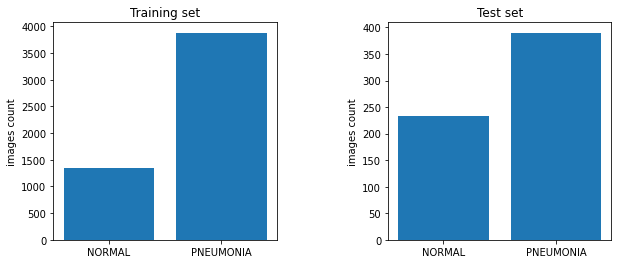

In [96]:
x = [0,1]
lables = ['NORMAL', 'PNEUMONIA']
values = [COUNT_NORMAL_TV, COUNT_PNEUMONIA_TV]
values2 = [COUNT_NORMAL_TEST, COUNT_PNEUMONIA_TEST]

plt.figure(1, figsize=(10,4))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.bar(x, values)
plt.xticks(x, lables)
plt.ylabel('images count')
plt.title('Training set')

plt.subplot(1,2,2)
plt.bar(x, values2)
plt.xticks(x, lables)
plt.ylabel('images count')
plt.title('Test set')
plt.show()

Training , Test set 모두 정상인 이미지가 폐렴 이미지에 비해 적다. 테스트셋은 평가를 위해 쓰이니 그대로두고, 훈련용 데이터의 경우 데이터의 불균형인 부분을 해결해주어야 할것같다. CNN 모델의 경우 데이터가 balance할수록 training이 잘된다고 한다.

데이터가 불균형한 부분을 이전 LMS에서는  **Weight balancing**이라는 테크닉을 사용하였는데 이번 프로젝트에서는 텐서플로우 API에서 지원하는 Image Augmentation을 시도해 보겠다.


### 입력 파이프라인을 이용하여 데이터셋 구성
 tf.data.Dataset API를 이용하여 데이터셋을 구성하는 함수를 정의하고 실제 데이터셋을 구성하겠다.


In [97]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

# 입력 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수있도록 설정
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [98]:
#---------------------------------------------------------------------
# 이미지 파일목록  Dataset 설정
#---------------------------------------------------------------------
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

#---------------------------------------------------------------------
# 이미지 파일의 경로 정보로 이미지와 라벨로 구성된 Dataset 설정 
#---------------------------------------------------------------------
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#---------------------------------------------------------------------
# 입력 파이프라인을 이용한 Dataset 설정 , 테스트셋에는 배치 사이즈만 설정
#---------------------------------------------------------------------
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
test_ds = test_ds.batch(BATCH_SIZE)

### 입력 데이터 확인
데이터셋이 잘구성되었는지 이미지 배치중 일부만 확인해보겠다.


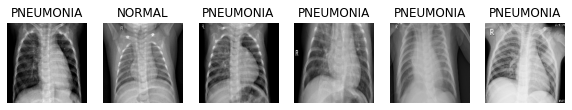

In [10]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,20))
    for n in range(6):
        ax = plt.subplot(1,6, n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 모델 설계 1 - baseline

우선 baseline 모델의 성능을 확인해보자. Weight balancing을 위해 설정해주었던 부분을 빼고 기본 모델의 성능을 확인해보겠다.

### 주요 함수 
- SeparableConv2D
 - depthwise separable convolution(깊이별 분리 합성곱)
 - 입력 채널별로 따로따로 공간 방향의 합성곱을 수행하여 모델 파라미터와 연산수를 줄여준다.
- BatchNormalization(배치정규화)
 - 훈련한는 동안 평균과 분산이 바뀌더라도 이에 적응하여 데이터를 정규화
 - 많은 연산과정이 발생하는 Convoluter Layer 또는 Fully Connected Layer 등의 layer 뒤에 적용
- MaxPool2D
 - convolution layer의 계산 결과(feature maps)에서 대표 특징을 뽑아 sub sampling
 - pooling 연산은 정규화 기법 적용이 끝난 뒤에 적용하는 것이 효과적

In [12]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([        
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [12]:
with tf.device('/GPU:0'):
    model1 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    history1 = model1.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/25
130/130 [==============================] - 88s 379ms/step - loss: 0.4961 - accuracy: 0.7683 - precision: 0.9207 - recall: 0.7536 - val_loss: 0.6360 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 48s 370ms/step - loss: 0.2138 - accuracy: 0.9228 - precision: 0.9547 - recall: 0.9408 - val_loss: 0.9888 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 49s 379ms/step - loss: 0.1615 - accuracy: 0.9462 - precision: 0.9641 - recall: 0.9635 - val_loss: 1.0301 - val_accuracy: 0.7393 - val_precision: 0.7393 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 50s 389ms/step - loss: 0.1344 - accuracy: 0.9543 - precision: 0.9677 - recall: 0.9709 - val_loss: 1.2697 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 50s 386ms/step - loss: 0.1137 - accura

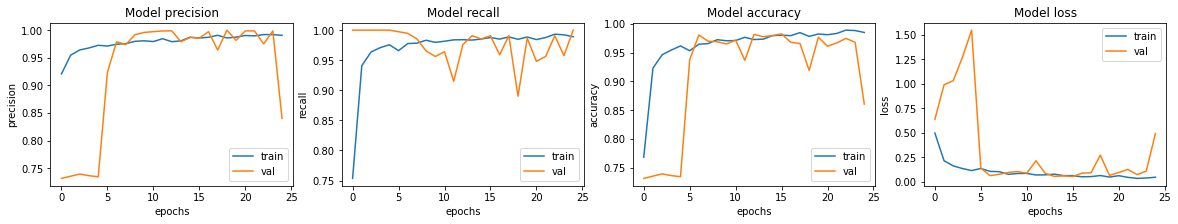

In [13]:
def show_history(history):
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

show_history(history1)

In [15]:
loss, accuracy, precision, recall = model1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 225ms/step - loss: 2.4421 - accuracy: 0.6410 - precision: 0.6352 - recall: 1.0000
Loss: 2.4420857429504395,
Accuracy: 0.6410256624221802,
Precision: 0.6351791620254517,
Recall: 1.0


기본 데이터로 모델 학습시 과적합이 되어 검증점수가 낮게 나왔고 테스트 셋에서 정확도가 64점밖에 되지 않는다. 기존 LMS에서 Weight balancing 설정을 뺀것일 뿐인데 학습이 제대로 되지않았다. 폐렴 데이터가 불균형한 것이 확실히 문제가 되는것 같고 Weight balancing 설정만으로 테스트점수가 85가 나왔다면 좋은 접근방법이였던것 같다.

## 모델 설계 2 - 전처리 레이어에 Augmentation 적용

참고 : [텐서플로 튜토리얼](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko)

케라스의 전처리 레이어를 사용해 이미지의 크기, 배율을 조정하거나 Augmentation을 적용할수있다.
전처리할 사항을 모델 설계시 추가하면 순전파시 실시간으로 Augmentation이 이뤄지며 매학습마다 다른 이미지가 생성되어 학습된다.

모델 학습전에 Augmentation이 잘되는지 확인해보자.

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

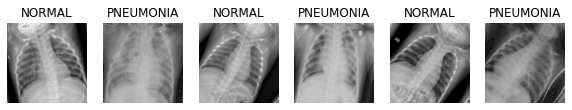

In [35]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,20))
    for n in range(6):
        ax = plt.subplot(1,6, n+1)
        aug_img = data_augmentation(image_batch[n])
        plt.imshow(aug_img)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

이미지가 잘 변화된것을 확인할 수 있다. 
너무 많은 증강옵션은 학습을 어렵게 만든다고하여 일단 RandomFlip과 RandomRotation 을 적용하여 모델을 다시 학습해보겠다.

In [38]:
def build_model2(): 
    model = tf.keras.Sequential([
        data_augmentation,        #<------------------------ 이미지 증강 적용
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [39]:
with tf.device('/GPU:0'):
    model2 = build_model2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    history2 = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/25
130/130 [==============================] - 58s 371ms/step - loss: 0.4806 - accuracy: 0.7894 - precision: 0.9282 - recall: 0.7771 - val_loss: 0.6465 - val_accuracy: 0.7393 - val_precision: 0.7393 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 48s 370ms/step - loss: 0.2722 - accuracy: 0.9000 - precision: 0.9434 - recall: 0.9208 - val_loss: 0.8570 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 48s 374ms/step - loss: 0.2225 - accuracy: 0.9207 - precision: 0.9482 - recall: 0.9451 - val_loss: 0.9828 - val_accuracy: 0.7402 - val_precision: 0.7402 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 49s 377ms/step - loss: 0.2050 - accuracy: 0.9216 - precision: 0.9435 - recall: 0.9515 - val_loss: 1.2962 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 50s 387ms/step - loss: 0.1723 - accura

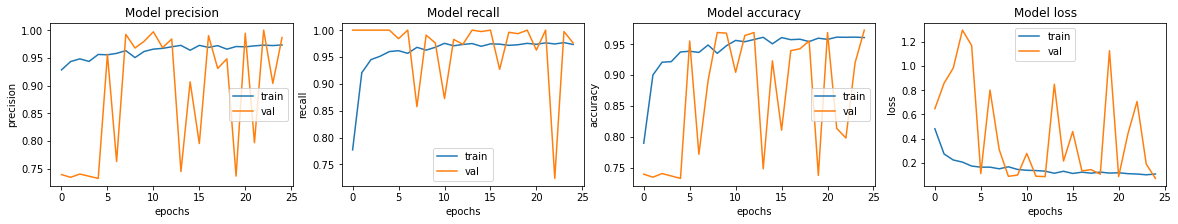

In [40]:
show_history(history2)

In [41]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 207ms/step - loss: 0.5451 - accuracy: 0.8029 - precision: 0.7633 - recall: 0.9923
Loss: 0.5450769662857056,
Accuracy: 0.8028846383094788,
Precision: 0.7633135914802551,
Recall: 0.9923076629638672


RandomFlip과 RandomRotation 을 적용하여 정확도가 80점까지 향상되었다. 특이한점은 에폭시마다 성능지표가 들쭉날쭉하는 모습을 보이고 있는부분인데, 데이터 불균형인 상태를 해결하기위해 이미지 증강을 적용한것이 안정적이지 않아보인다. 다른 증강 방법을 더 추가하고싶지만 이부분은 의료 도메인에 대한 이해를 바탕으로 실험을 진행하는 것이 좋겠다. 

의료 이미지의 경우 단순히 이미지 추가만으로 augmentation적용하는것이 큰 도움이 되지 않을 것같다. 아마도 중요한 신체 기관, 조직등의 위치, 모양, 명암 등의 정보가 잘유지되도록 증강기법을 적용해야 하기 때문일것같다. 


## 의료 사진에 효과적인 증강방법은?
의료분야에서 Data augmentation 방법으로 많이 사용되는 가우시안 노이즈를 이미지 증강레이어 이후에 한번더 적용해보겠다.


## 모델 설계 3 - 가우시안 노이즈 추가

In [43]:
def build_model3(): 
    model = tf.keras.Sequential([
        data_augmentation,   
        tf.keras.layers.GaussianNoise(0.05), #<------------------------ 가우시안 노이즈 추가
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [44]:
with tf.device('/GPU:0'):
    model3 = build_model3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/25
130/130 [==============================] - 58s 371ms/step - loss: 0.4820 - accuracy: 0.7933 - precision: 0.9202 - recall: 0.7906 - val_loss: 0.6739 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 48s 370ms/step - loss: 0.2573 - accuracy: 0.9072 - precision: 0.9437 - recall: 0.9309 - val_loss: 0.8824 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 48s 370ms/step - loss: 0.2075 - accuracy: 0.9267 - precision: 0.9491 - recall: 0.9525 - val_loss: 1.1182 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 48s 374ms/step - loss: 0.2059 - accuracy: 0.9250 - precision: 0.9502 - recall: 0.9490 - val_loss: 1.3977 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 50s 384ms/step - loss: 0.1747 - accura

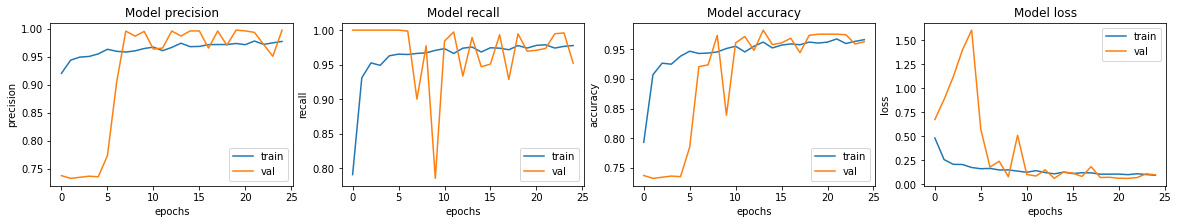

In [47]:
show_history(history3)

In [48]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 214ms/step - loss: 0.3953 - accuracy: 0.8734 - precision: 0.8479 - recall: 0.9718
Loss: 0.3953033983707428,
Accuracy: 0.8733974099159241,
Precision: 0.8478747010231018,
Recall: 0.971794843673706


가우시안 노이즈가 규제의 작용을 했는지 로스값이 아주 안정적으로 수렴하는 모습을 보였는데 역시나 테스트셋에서 좋은 성능이 나왔다.
이 모델에서 모델 구조를 변경하거나 하이퍼파라미터를 조정해 성능을 좀더 올릴수 있는지 확인해보겠다. (각각의 훈련 코드나 로그는 생략하고 테스트셋의 결과만 정리)

---
## 모델 성능 분석

|모델|상세|Accuracy|Loss|Precision|Recall|
|:---|:---|---|---|---|---|
| 1 | baseline - CNN 분류 모델  | 0.6410 | 2.4420 | 0.6352 | 1.0 |
| 2 | 1번모델 + Agumentaion | 0.8028 | 0.5450 | 0.7633 | 0.9923 |
| 3 | 2번모델 + GaussianNoise 0.05 | 0.8734 | 0.3953 |0.8478 | 0.9717 |
| 4 | 2번모델 + GaussianNoise 0.1 | 0.8622 | 0.4355 | 0.8393 | 0.9641 |
| 5 | 2번모델 + GaussianNoise 0.01 | 0.7708 | 0.7117 | 0.7335 | 0.9949 |
| 6 | 3번모델 + 필터사이즈 5 |0.7676 | 0.7519 | 0.7307 | 0.9949 |
| 7 | 3번모델 + 필터사이즈 2  | 0.6538 | 1.4602 | 0.6440 | 0.9974 |
| 8 | 3번모델 + conv_block 추가 |0.8622 | 0.3755 | 0.8486 | 0.9487 |
| 9 | 3번모델 + BatchNormalization 추가  |0.8333 | 0.5677 | 0.7955 | 0.9872 |


모델1에서는 폐렴인 경우가 많은 상태(데이터 불균형이 있는 상태에서) 폐렴 데이터를 잘 맞춰 재현율이 높게나온것 같다. 반면에 정상인 케이스에 대한 학습이 이뤄지지 않아 전반적인 정확도 점수가 낮다.

모델 2에서도 폐렴, 정상인 경우 둘다에 이미지 증강을 적용하였기때문에 모델1과 비슷한 재현율이 나온것 같다. 대신 증가된 데이터로 학습을 해선지 정확도와 정밀도가 함께 높아졌다.

모델 3에서는 Image augmentation에 대해 다른 방법을 적용하기 보다 과적합을 완화하는데 유용한 가우시안 노이즈를 모델에 적용해보았다. 
에폭 25회까지 안정적으로 손실값이 줄어드는것을 보여주었다. 이전 모델에서는 그래프가 오르락내리락하여 성능이 신뢰가 가지않는 반면에 모든지표가 안정적으로 수렴하는 모습이였다. 

모델 3을 기준으로 하이퍼파라미터 튜닝이나 모델 구조변경을 시도해보았는데 크게 성능 개선이 이루어 지지않았다. conv 레이어를 가우시안 노이즈 아래에 한층 더 추가한것은 3번 모델보다 손실값은 적었지만 다른 지표가 향상되지않았다. 



---
# 정리

성능 향상을 결정하는 가장 중요한 요소는 학습데이터이기라는것을 다시알게되었다. 학습에서 훈련 정확도가 95점이상으로 나오는 모델이 많았지만 데이터 불균형이 학습에 영향을 주었는지 테스트에서는 모든지표값이 훈련점수와 큰 차이를 보였다.

불균형 데이터를 보완하기위해 정상이미지에 대한 오버샘플링(정상이미지 복사, 이미지증강으로 데이터셋추가)도 진행해보았지만 3번모델의 성능 만큼 나오지 않았다. 다음번에 기회가된다면 GAN이나 오버샘플링기법을 좀더 적용해보면좋겠다.
아직 해보지 않은 시도가 많지만 이전에 해보지 않은 데이터 증강을 통해 모델 성능 향상을 이루어서 재밌었던 프로젝트였던것 같다.

이번에 적용했던 실험 기법과 다음에 시도해볼 것들을 정리하며 프로젝트를 마치겠다.

- 데이터 증강 : 모델 설계시 전처리 레이어에 적용
- 가우시안 노이즈 적용
- 불균형 데이터 해결 : Oversampling을 위해 데이터 증강으로 가짜 샘플 추가
- 규제의 적용 : BatchNormalization, Dropout 비율변경
- 모델의 개선 :  Convolution filter 사이즈 변경

다음 과제...
- 하이퍼 파라미터의 변경: batch size, optimizer, learning rate, epoch횟수
- 모델의 개선 : 채널 개수, activation 함수변경, 모델 구조 변경
- 이미지 증강 : GAN, ImageDataGenerator 클래스의 활용한 이미지 증강
    



---
## Reference

- [딥러닝 기반 의료영상 분석을 위한 데이터 증강 기법](https://jksronline.org/pdf/10.3348/jksr.2020.0158)
- [tensorflow 2.0 Dataset](https://hiseon.me/data-analytics/tensorflow/tensorflow-dataset/)
- [tensorflow 2.0 Dataset API](https://m.blog.naver.com/euue717/222086046496)
- [입력 파이프라인 빌드](https://www.tensorflow.org/guide/data?hl=ko)
- [Image augmentation](https://wiserloner.tistory.com/1244)
- [데이터불균형](https://hwiyong.tistory.com/266)
- [딥러닝을 위한 고급도구](https://subinium.github.io/Keras-7/)